# Exploring Sonoma County animal shelter intake and outcome data 
## Data source
For this data analysis, we are using the Sonoma County Animal Shelter Intake and Outcome dataset collected and made publicly available by Sonoma County with the purpose of helping the community better understand the animals being cared for by the shelter.

The dataset includes each animal’s name, type, breed, color, sex, size, date of birth, kennel/impound details and ID, intake/outcome date, days in shelter, intake/outcome types, health condition, and outcome location. The data spans from August 2013 to May 2023.
## Questions we seek to answer
- What types of animals are cared for by the shelter?
- Has the number of intakes increased or decreased over time?
- During which month does the shelter have the most intakes?
- What are the most common outcomes?
- During which month does the shelter have the most adoptions?
- Does age affect the likelihood of an animal's adoption?
- Is age a factor in how long an animal stays at the shelter?
- Is gender a factor in how long an animal stays at the shelter?

## Importing needed libraries/modules and reading the data from the CSV

In [1]:
# Importing needed libraries/modules
from pandas import read_csv, to_datetime, Series
import numpy as np
import project_functions

# Open data file
df = read_csv('intake_and_outcome_data.csv')

## Cleaning/converting the name; birth, intake, and outcome date; and outcome type columns

In [13]:
# Replacing all NaN values of name column with "No name"
df["Name"].fillna("No name", inplace=True)

# Converts string dates to datetime dtypes
df["Date Of Birth"] = to_datetime(df["Date Of Birth"])
df["Intake Date"] = to_datetime(df["Intake Date"])
df["Outcome Date"] = to_datetime(df["Outcome Date"])

df["Outcome Type"].fillna("Pending", inplace=True)

## Finding and adding Age In Days column

In [3]:
# Find age in days of animal on intake date if birth date provided
birth_dates = np.array(df["Date Of Birth"], dtype='datetime64[D]')
intake_dates = np.array(df["Intake Date"], dtype='datetime64[D]')
ages = np.array((intake_dates - birth_dates), dtype="int")
ages = np.where(ages < 0, 0, ages) # changes age to zero if born after intake
ages = np.where(np.isnat(birth_dates), np.nan, ages) # gives NaN value if no birthday provided and changes dtype to float64
df['Age In Days'] = ages

# Calculate average age of animals excluding those with unknown birth dates
avg_age_in_years = np.nanmean(ages)/365.24
np.around(avg_age_in_years, decimals=2)

3.43

## Animal types ~Feel free to work on this

In [ ]:
## Add pie chart for animal types coming into the shelter?

## Animal intakes per month
To better see the data for each year, we can plot monthly intakes for whole years included in the data set (2014-2022) based on user input. To do this, we create a pandas dataframe based on the inputted year and use dt.month.value_counts() to get a count of each month in the dataframe. We then plot this information on a bar graph.

### Average animal intakes per month
We also wanted to find out how many intakes the shelter has on average for each month of the year. We use dt.month.value_counts() to get a count of the total number of intakes for each month for all years. To find the average of each month, we divide the total intakes for each month by the number of years in the dataset.


Enter a year between 2013 and 2023 to view number of intakes per month:  2013


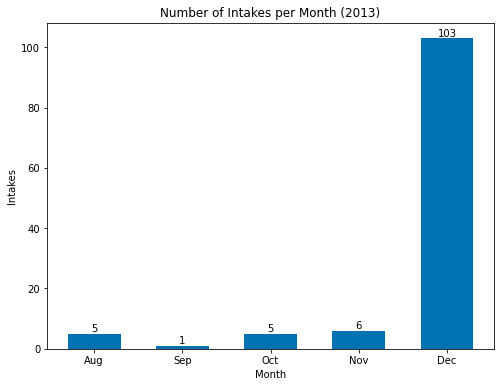

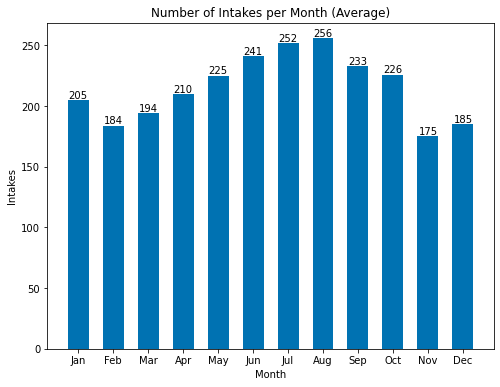

In [7]:
# Find number of intakes by month for specific year
year = input("Enter a year between 2013 and 2023 to view number of "
             "intakes per month: ")
while not year.isnumeric() or int(year) > 2023 or int(year) < 2013:
    year = input("Enter a year between 2013 and 2023 to view number of "
                 "intakes per month: ")
df_in_date = df[df["Intake Date"].dt.strftime("%Y") == f"{year}"]
total_annual_intakes = len(df_in_date.index)
monthly_intakes = Series.sort_index(df_in_date["Intake Date"].
                                    dt.month.value_counts())

# Plot monthly intakes
project_functions.monthly_in_out(monthly_intakes, year, "Intakes")

# Find average number of intakes for each month
all_monthly_intakes = (Series.sort_index(df["Intake Date"].dt.month.value_counts())).to_numpy() 
num_of_years = round((df["Intake Date"].max()-df["Intake Date"].min())/np.timedelta64(1, 'Y'), 2)
avg_monthly_intakes = Series((all_monthly_intakes/num_of_years).round(decimals=0), index=[x for x in range(1, 13)])

project_functions.monthly_in_out(avg_monthly_intakes, "Average", "Intakes")

## Outcomes per month
Note: There were no outcomes listed for 2013.

Enter a year between 2014 and 2023 to view number of outcomes per month:  2013
Enter a year between 2014 and 2023 to view number of outcomes per month:  2020


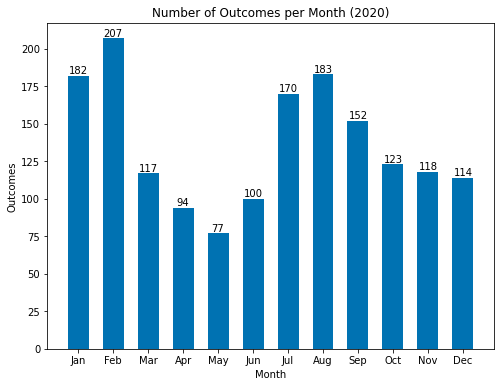

RETURN TO OWNER    8448
ADOPTION           7362
TRANSFER           5278
EUTHANIZE          3465
DISPOSAL            229
Unknown             171
DIED                167
RTOS                 48
ESCAPED/STOLEN       17
Name: Outcome Type, dtype: int64


In [14]:
# Find number of outcomes by month for specific year
year = input("Enter a year between 2014 and 2023 to view number of "
             "outcomes per month: ")
while not year.isnumeric() or int(year) > 2023 or int(year) < 2014:
    year = input("Enter a year between 2014 and 2023 to view number of "
                 "outcomes per month: ")
df_out_date = df[df["Outcome Date"].dt.strftime("%Y") == f"{year}"]
total_annual_outcomes = len(df_out_date.index)
monthly_outcomes = Series.sort_index(df_out_date["Outcome Date"].
                                     dt.month.value_counts())
# Plot monthly outcomes
project_functions.monthly_in_out(monthly_outcomes, year, "Outcomes")

# Plot outcome types (working on this next ~Cilla)
outcome_types = df["Outcome Type"].value_counts()
print(outcome_types)



## Animal adoption rate (working on this next ~Cilla)

In [ ]:
# Plot intakes/adoptions grouped 
# project_functions.monthly_in_out_grouped(monthly_intakes, adoptions, year)